In [13]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session

In [14]:
bucket_name = 'bigdata940' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [15]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [16]:
# set an output path where the trained model will be saved
prefix = 'model'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://bigdata940/model/output


In [17]:
!pip install kagglehub -q

In [18]:
import pandas as pd
from io import StringIO

# Set up AWS S3 client
s3 = boto3.client('s3')

# Define your S3 bucket name and the file path (object key) in the bucket
bucket_name = bucket_name
file_key = 'preprocessed.csv'  # Update with the correct path and file name in S3

# Download the file from S3 to memory
try:
    s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
    file_content = s3_object['Body'].read().decode('utf-8')  # Read and decode the file content as a string

    # Use StringIO to read the string content as if it were a file
    data = pd.read_csv(StringIO(file_content))
    data

except Exception as e:
    print(f"Error loading data from S3: {e}")


In [19]:
data = pd.read_csv('preprocessed.csv')
data

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24T11:50:39.000Z,2294359932054536986,1515966223509089906,2268105426648170900,electronics.tablet,samsung,162.01,1515915625441993984
1,2020-04-24T11:50:39.000Z,2294359932054536986,1515966223509089906,2268105426648170900,electronics.tablet,samsung,162.01,1515915625441993984
2,2020-04-24T14:37:43.000Z,2294444024058086220,2273948319057183658,2268105430162997728,electronics.audio.headphone,huawei,77.52,1515915625447879434
3,2020-04-24T14:37:43.000Z,2294444024058086220,2273948319057183658,2268105430162997728,electronics.audio.headphone,huawei,77.52,1515915625447879434
4,2020-04-26T08:45:57.000Z,2295716521449619559,1515966223509261697,2268105442636858090,furniture.kitchen.table,maestro,39.33,1515915625450382722
...,...,...,...,...,...,...,...,...
420713,2020-11-21T10:08:54.000Z,2388440981134693941,1515966223509088622,2374498914000592280,electronics.video.tv,lg,370.35,1515915625513809944
420714,2020-11-21T10:10:01.000Z,2388440981134693942,1515966223526602848,2268105428166508982,electronics.smartphone,oppo,138.87,1515915625514888605
420715,2020-11-21T10:10:13.000Z,2388440981134693943,1515966223509089282,2268105428166508982,electronics.smartphone,apple,418.96,1515915625514891148
420716,2020-11-21T10:10:30.000Z,2388440981134693944,1515966223509089917,2268105402447037312,appliances.personal.scales,vitek,12.48,1515915625514834281


In [24]:
data.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24T11:50:39.000Z,2294359932054536986,1515966223509089906,2268105426648170900,electronics.tablet,samsung,162.01,1515915625441993984
1,2020-04-24T11:50:39.000Z,2294359932054536986,1515966223509089906,2268105426648170900,electronics.tablet,samsung,162.01,1515915625441993984
2,2020-04-24T14:37:43.000Z,2294444024058086220,2273948319057183658,2268105430162997728,electronics.audio.headphone,huawei,77.52,1515915625447879434
3,2020-04-24T14:37:43.000Z,2294444024058086220,2273948319057183658,2268105430162997728,electronics.audio.headphone,huawei,77.52,1515915625447879434
4,2020-04-26T08:45:57.000Z,2295716521449619559,1515966223509261697,2268105442636858090,furniture.kitchen.table,maestro,39.33,1515915625450382722


## Predicting Top 2 Categories That Will Do Well in the Future

In [32]:
# Step 1: Aggregate Sales Data by Category
category_performance = df.groupby('category_code').agg({
    'price': 'mean',  # Mean price
    'order_id': 'nunique',  # Number of orders
    'product_id': 'nunique'  # Number of unique products
}).reset_index()

# Step 2: Feature Engineering (you can add more features like average rating, etc.)
category_performance['total_sales'] = category_performance['order_id'] * category_performance['price']

# Step 3: Split Data for Model Training
X = category_performance[['price', 'order_id', 'product_id']]
y = category_performance['total_sales']  # This will be your target variable (sales)

# Step 4: Train a Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Predict Future Sales
category_performance['predicted_sales'] = model.predict(X)

# Step 6: Rank Categories by Predicted Sales
top_2_categories = category_performance.nlargest(2, 'predicted_sales')
print("Top 2 categories predicted to do well in the future:")
print(top_2_categories[['category_code', 'predicted_sales']])


Top 2 categories predicted to do well in the future:
    category_code  predicted_sales
88             88     2.474216e+07
58             58     1.245991e+07


## Predict how many people are likely to purchase products from two or more specific categories

In [47]:
import pandas as pd
import numpy as np

# Assuming 'data' is your main DataFrame
# Convert 'event_time' to datetime format
data['event_time'] = pd.to_datetime(data['event_time'])

# Extract features from 'event_time'
data['month'] = data['event_time'].dt.month
data['day_of_week'] = data['event_time'].dt.dayofweek

# Filter out rows where 'category_code' or 'user_id' is missing
data = data.dropna(subset=['category_code', 'user_id'])

# Create a pivot table for category purchases per user
user_category_df = data.groupby(['user_id', 'category_code']).agg(
    total_spent=('price', 'sum'),
    purchase_count=('order_id', 'nunique')
).reset_index()

# Aggregate features for each user
user_agg_df = user_category_df.groupby('user_id').agg(
    distinct_categories=('category_code', 'nunique'),
    total_purchases=('purchase_count', 'sum'),
    total_spent=('total_spent', 'sum')
).reset_index()

# Create a target variable: 1 if user bought from 2 or more categories, else 0
user_agg_df['multi_category_purchase'] = np.where(user_agg_df['distinct_categories'] >= 2, 1, 0)

# Display the first few rows of user_agg_df to verify
print(user_agg_df.head())

               user_id  distinct_categories  total_purchases  total_spent  \
0  1515915625439952115                    1                1       416.64   
1  1515915625440038436                    2                2        56.43   
2  1515915625440051468                    6                8      5984.92   
3  1515915625440099873                    5                5      3785.72   
4  1515915625440121544                    2                2       182.83   

   multi_category_purchase  
0                        0  
1                        1  
2                        1  
3                        1  
4                        1  


## Model Training

Training Random Forest: 100%|██████████| 100/100 [08:26<00:00,  5.07s/it]


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     43288
           1       1.00      1.00      1.00     17756

    accuracy                           1.00     61044
   macro avg       1.00      1.00      1.00     61044
weighted avg       1.00      1.00      1.00     61044



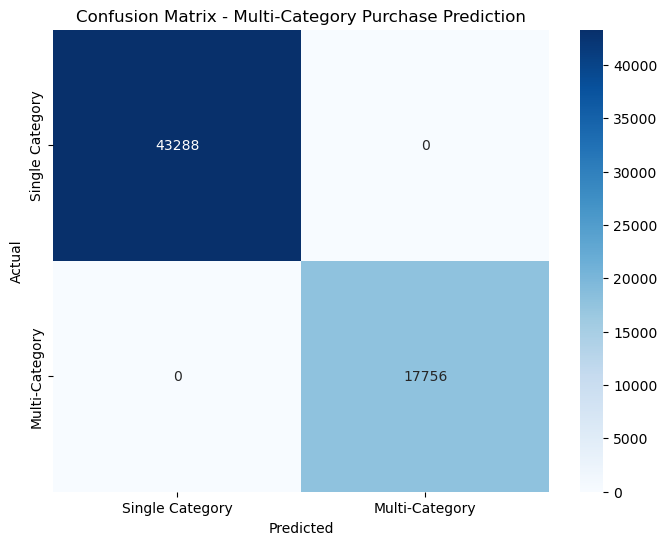

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # For adding a progress bar

# Custom wrapper to enable progress bar for Random Forest
class RandomForestWithProgressBar(RandomForestClassifier):
    def fit(self, X, y):
        # Create a tqdm progress bar
        for i in tqdm(range(self.n_estimators), desc="Training Random Forest", leave=True):
            super().fit(X, y)
        return self

# Define features and target
features = user_agg_df[['total_purchases', 'total_spent', 'distinct_categories']]
target = user_agg_df['multi_category_purchase']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Train a Random Forest Classifier with Progress Bar
model = RandomForestWithProgressBar(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", class_report)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Single Category', 'Multi-Category'], yticklabels=['Single Category', 'Multi-Category'])
plt.title("Confusion Matrix - Multi-Category Purchase Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Model Deploy

In [53]:
import pickle

# Save the trained model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [54]:
import boto3

# Initialize the S3 client
s3 = boto3.client('s3')

# Upload the file
s3.upload_file('random_forest_model.pkl', 'bigdata940', 'models/random_forest_model.pkl')


In [55]:
import sagemaker
from sagemaker import get_execution_role
role = get_execution_role()  # Get the execution role for SageMaker

In [ ]:
from sagemaker.sklearn import SKLearnModel

# Define the path to the model in S3
model_data = 's3://bigdata940/models/random_forest_model.pkl'

# Create the SageMaker model
sklearn_model = SKLearnModel(
    model_data=model_data,
    role=role,
    entry_point='https://bigdata940.s3.us-east-1.amazonaws.com/models/interface.py'  # This file contains the logic to handle predictions
)


In [ ]:
# Deploy the model to an endpoint
predictor = sklearn_model.deploy(
    initial_instance_count=1,  # Number of instances to run
    instance_type='ml.m5.large'  # Type of instance (can choose based on workload)
)

In [65]:
# Make predictions by invoking the endpoint
response = predictor.predict([[5, 3, 2]])  # Example feature data for prediction
print(response)

0  1515915625439952115                    1                1       416.64


In [67]:
predictor.delete_endpoint()

Endpoint Deleted
